In [4]:
import pandas as pd, numpy as  np
import matplotlib.pyplot as plt

In [5]:
columns = [i for i in range(17)]
columns[0] = "Timestamp"
# AnimalName = input('Animal Name: ')
video_timestamps = pd.read_csv(r'm19_csvforvideo_2021-07-19T11_35_41.csv', names=columns).dropna(axis=0, how='all')
##read photometry
photom = pd.read_csv(r'm19_SignalPercentDelta.csv').dropna(axis=0, how='all')


In [7]:
DLC    = pd.read_csv(r"m19_Video_2021-07-19T11_35_42DLC_resnet50_OpenFieldJul2shuffle1_1030000.csv", skiprows=1, index_col=None).dropna(axis=0, how='all')
arena_names = ['TopLeft', 'TopRight', 'BottomLeft', 'BottomRight']
for name in arena_names:
        mask = [name in col for col in DLC.columns]
        DLC.drop(DLC.columns[mask], axis=1, inplace=True)
        
DLC_vals = DLC.values
DLC = pd.DataFrame(DLC_vals[1:], columns = DLC_vals[0], dtype=np.float32)
video_copy = video_timestamps.copy()
if len(DLC)!=len(video_copy):
    print("The scored behaviour and DLC files are not the same length!")
    diff = len(DLC) - len(video_copy)
    if diff>0:
        print(f"The DLC file is {abs(diff)} frames longer than the video file")
        DLC = DLC.iloc[:len(video_copy)]
    if diff<0:
        print(f"The DLC file is {abs(diff)} frames shorter than the video file")
        video_copy = video_copy.iloc[:len(DLC)]
    print("we may proceed but make sure they are from the same experiment")
    
mask = (DLC.likelihood<0.7).any(axis=1)
mask = mask.values
xcopy = DLC['x']
ycopy = DLC['y']
xcopy[mask]= np.nan
ycopy[mask]= np.nan
DLC['x'] = xcopy
DLC['y'] = ycopy
mean_x  = (np.nanmean(DLC['x'], axis=1))
mean_y =  (np.nanmean(DLC['y'], axis=1))
DLC_XY = pd.DataFrame({'Timestamp':video_timestamps.Timestamp,'x':mean_x, 'y':mean_y})

The scored behaviour and DLC files are not the same length!
The DLC file is 15 frames longer than the video file
we may proceed but make sure they are from the same experiment


C:\Users\harry\miniconda3\envs\Data_Analysis\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\harry\miniconda3\envs\Data_Analysis\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\harry\miniconda3\envs\Data_Analysis\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
C:\Users\harry\miniconda3\envs\Data_Analysis\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slic

In [8]:
DLC_XY

,Timestamp,x,y
0,1196.235520,NaN,NaN
1,1196.235520,NaN,NaN
2,1196.285536,NaN,NaN
3,1196.335520,NaN,NaN
4,1196.335520,NaN,NaN
...,...,...,...
95128,4367.422112,269.959534,330.901276
95129,4367.472096,269.564819,330.683655
95130,4367.522112,281.447845,343.685944
95131,4367.522112,267.148651,330.474396


In [9]:
photom = photom.rename(columns={'frame':'photom_frame'})
DLC_XY.set_index('Timestamp', inplace=True)
photom.set_index('Timestamp', inplace=True)
photom = DLC_XY.join(photom, how='outer')

In [255]:
bin_size = 100
heatmap, xedges, yedges = np.histogram2d(x, y, bins=bin_size)


In [14]:
x[x>0]

Timestamp
1214.735680    334.105255
1291.936448     99.755066
1291.936448    307.475708
1291.986464    233.945923
1292.036448    260.929504
                  ...    
4367.422112    269.959534
4367.472096    269.564819
4367.522112    281.447845
4367.522112    267.148651
4367.572096    265.712616
Name: x, Length: 84490, dtype: float32

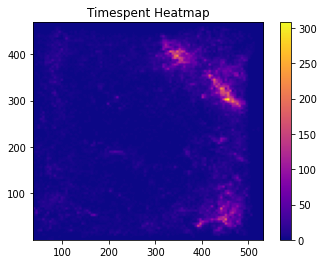

In [35]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

##Get x and y coords
x,y  = photom.x, photom.y
x = x.fillna(0)
y = y.fillna(0)
##bin coords in a 2D histogram
bin_size=100
heatmap, xedges, yedges = np.histogram2d(x[(x>0) & (y>0)], y[(x>0) & (y>0)], bins=bin_size)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]





# heatmap=np.reshape(heat, (bin_size,bin_size))
# scale_factor=4
# heatmap_big = np.kron(heatmap, np.ones((scale_factor,scale_factor)))
# print(heatmap_big.shape)
# print('smoothing...')
# heatmap_smooth = gaussian_filter(heatmap_big, sigma=scale_factor/2)

# plt.clf()
# ##cmap gives it a cool firey look
plt.title("Timespent Heatmap")
plt.imshow(heatmap, cmap = 'plasma',extent=extent, origin='lower')
plt.colorbar()


plt.show()


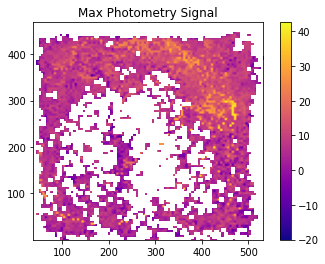

In [36]:
xprev = 0
yprev = 0
box_grids = []
sig_copy = photom.signal.copy()
photom_heat = []
testx_grid = []
testy_grid = []
count=0
testlist = []
for ygrid in yedges[1:]:
    for xgrid in xedges[1:]:
        isin_box = (photom.x>xprev) & (photom.y>yprev) & (photom.x<xgrid) & (photom.y<ygrid)
        count+=1
        testlist.append((np.sum(isin_box)))
        grid_index = np.where(isin_box)[0]
        photom_heat.append(np.max(sig_copy.iloc[grid_index]))
        testx_grid.append((xgrid))
        testy_grid.append((ygrid))
        xprev = xgrid
    yprev = ygrid
heat = np.reshape(photom_heat, (bin_size, bin_size))
plt.title("Max Photometry Signal")
plt.imshow(heat, cmap = 'plasma',extent=extent, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
xprev = 0
yprev = 0
box_grids = []
sig_copy = photom.signal.copy()
photom_heat = []
testx_grid = []
testy_grid = []
count=0
testlist = []
for ygrid in yedges[1:]:
    for xgrid in xedges[1:]:
        isin_box = (photom.x>xprev) & (photom.y>yprev) & (photom.x<xgrid) & (photom.y<ygrid)
        count+=1
        testlist.append((np.sum(isin_box)))
        grid_index = np.where(isin_box)[0]
        photom_heat.append(np.nanmean(sig_copy.iloc[grid_index]))
        testx_grid.append((xgrid))
        testy_grid.append((ygrid))
        xprev = xgrid
    yprev = ygrid
heat = np.reshape(photom_heat, (bin_size, bin_size))
plt.title("Mean Photometry Signal")
plt.imshow(heat, cmap = 'plasma',extent=extent, origin='lower')
plt.colorbar()
plt.show()

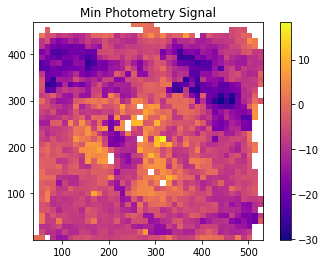

In [27]:
xprev = 0
yprev = 0
box_grids = []
sig_copy = photom.signal.copy()
photom_heat = []
testx_grid = []
testy_grid = []
count=0
testlist = []
for ygrid in yedges[1:]:
    for xgrid in xedges[1:]:
        isin_box = (photom.x>xprev) & (photom.y>yprev) & (photom.x<xgrid) & (photom.y<ygrid)
        count+=1
        testlist.append((np.sum(isin_box)))
        grid_index = np.where(isin_box)[0]
        photom_heat.append(np.min(sig_copy.iloc[grid_index]))
        testx_grid.append((xgrid))
        testy_grid.append((ygrid))
        xprev = xgrid
    yprev = ygrid
heat = np.reshape(photom_heat, (bin_size, bin_size))
plt.title("Min Photometry Signal")
plt.imshow(heat, cmap = 'plasma',extent=extent, origin='lower')
plt.colorbar()
plt.show()

In [182]:
heat[:,3]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])

In [151]:
np.reshape(testy_grid, (bin_size, bin_size))

array([[1.37002444e-01, 1.23598384e+01, 2.45826744e+01, ...,
        4.52381934e+02, 4.64604770e+02, 4.76827606e+02],
       [1.37002444e-01, 1.23598384e+01, 2.45826744e+01, ...,
        4.52381934e+02, 4.64604770e+02, 4.76827606e+02],
       [1.37002444e-01, 1.23598384e+01, 2.45826744e+01, ...,
        4.52381934e+02, 4.64604770e+02, 4.76827606e+02],
       ...,
       [1.37002444e-01, 1.23598384e+01, 2.45826744e+01, ...,
        4.52381934e+02, 4.64604770e+02, 4.76827606e+02],
       [1.37002444e-01, 1.23598384e+01, 2.45826744e+01, ...,
        4.52381934e+02, 4.64604770e+02, 4.76827606e+02],
       [1.37002444e-01, 1.23598384e+01, 2.45826744e+01, ...,
        4.52381934e+02, 4.64604770e+02, 4.76827606e+02]])

In [31]:
np.nanmean(np.array((9,9,3,np.nan,5)))

6.5

In [134]:
# heat = []
# for xgrid in xedges[1:]:
#     for ygrid in yedges[1:]:
#         isin_box = (mean_x>xprev) & (mean_y>yprev) & (mean_x<xgrid) & (mean_y<ygrid)
#         grid_index = np.where(isin_box)[0]
#         heat.append(np.mean(sig_copy.iloc[grid_index]))
#     xprev = xgrid

# heatmap=np.reshape(heat, (bin_size,bin_size))

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.2858519080611061,
 0.555189439235168,
 nan,
 nan,
 nan,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 9.47369597073506,
 6.411081283177075,
 6.411081283177075,
 3.917622818203799,
 3.401321809564703,
 nan,


(160, 160)
smoothing...


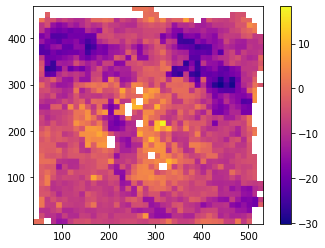

In [32]:
scale_factor=4
heatmap_big = np.kron(heat, np.ones((scale_factor,scale_factor)))
print(heatmap_big.shape)
print('smoothing...')
heatmap_smooth = gaussian_filter(heatmap_big, sigma=scale_factor/2)

plt.clf()
# ##cmap gives it a cool firey look
plt.imshow(heatmap_big, cmap = 'plasma',extent=extent, origin='lower')
plt.colorbar()

plt.show()